Necessary installs

In [2]:
#!pip install torch==1.13.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install transformers==4.30.0
!pip install datasets==2.13.2
!pip install accelerate -U
!pip install evaluate

In [3]:
# system packages
from pathlib import Path
import shutil
import urllib
import tarfile
import sys
import os
# data and numerical management packages
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pad_sequence

# useful during debugging (progress bars)
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

from transformers import set_seed
from transformers import AutoModelForSequenceClassification, RobertaModel
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import BertTokenizer, BertModel, AdamW, Trainer, TrainingArguments


import warnings
warnings.filterwarnings('ignore')

seed = 777
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

# Set seed for PyTorch on GPU (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

2024-02-21 09:04:31.593847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 09:04:31.593940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 09:04:31.762265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Load the data
dataset_folder = Path.cwd().joinpath('MELD_train_efr.json')
dataset_folder = "/kaggle/input/plaplapla/MELD_train_efr.json"
df = pd.read_json(dataset_folder)

In [7]:
df

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...,...
3995,utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3996,utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3997,utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3998,utterance_3998,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Distribution of Emotions

In [8]:
emotion_counts = df['emotions'].explode().value_counts()

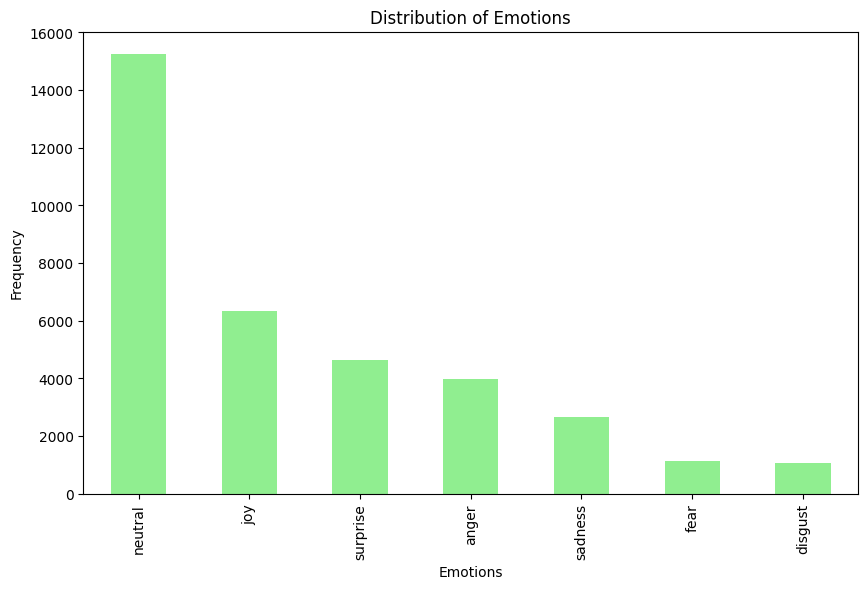

In [9]:
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.show()

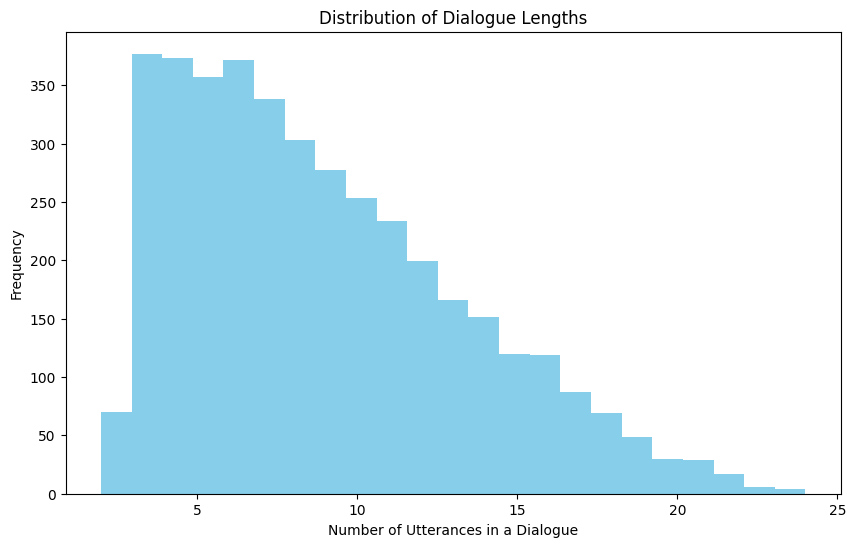

In [10]:
dialogue_lengths = [len(dialogue) for dialogue in df['utterances']]
dialogues_lengths_sorted = sorted(dialogue_lengths, reverse=True)
bins = np.unique(dialogues_lengths_sorted).shape[0]

plt.figure(figsize=(10, 6))
plt.hist(dialogues_lengths_sorted, bins=bins, color='skyblue')
plt.title('Distribution of Dialogue Lengths')
plt.xlabel('Number of Utterances in a Dialogue')
plt.ylabel('Frequency')
plt.show()


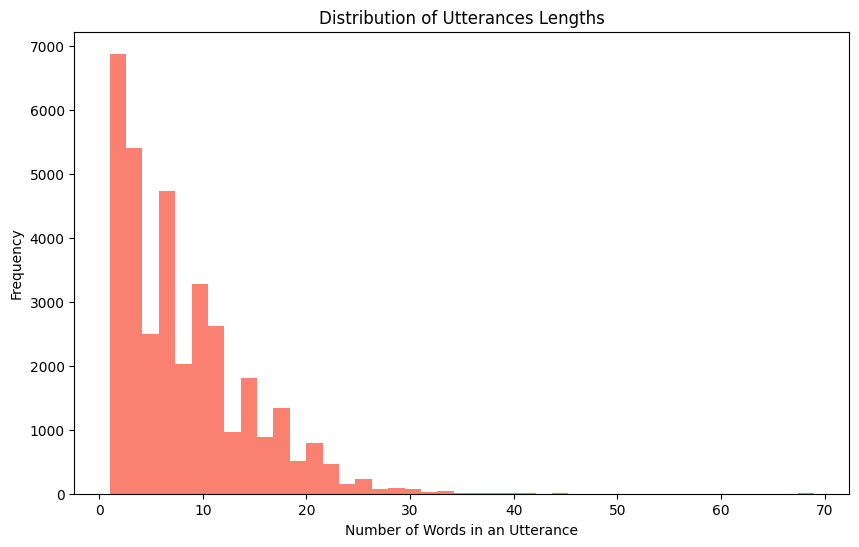

In [11]:
utterance_lengths = [sum(len(word.split()) for word in utterance.split()) for dialogue in df['utterances'] for utterance in dialogue]
utterances_lengths_sorted = sorted(utterance_lengths,reverse=True)
bins_2 = np.unique(utterances_lengths_sorted).shape[0]

plt.figure(figsize=(10, 6))
plt.hist(utterances_lengths_sorted, bins=bins_2, color='salmon')
plt.title('Distribution of Utterances Lengths')
plt.xlabel('Number of Words in an Utterance')
plt.ylabel('Frequency')
plt.show()

## Text Preprocessing

In [12]:
# Removing None, replacing with 0.0
triggers = df['triggers']
for row in range(triggers.shape[0]):
    for trigger in range(len(triggers[row])):
        if triggers[row][trigger] == None:
            triggers[row][trigger] = 0.0

df['triggers'] = triggers

In [13]:
emotions = df['emotions'].explode().unique()
emotions

array(['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust',
       'anger'], dtype=object)

In [14]:
triggers = df['triggers'].explode().unique()
triggers

array([0.0, 1.0], dtype=object)

In [15]:
sorted_emotions = sorted(emotions)  #sort the array because Binarizer will automatically do that for one hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(sorted_emotions)

dialogues = df['emotions']
one_hot_emotions = []
for dialogue_emotion in dialogues:
  dialogue_emotions_list = []
  for emotion in dialogue_emotion:
    encoded_emotion=label_binarizer.transform([emotion])
    dialogue_emotions_list.append(np.ravel(encoded_emotion).tolist())
  one_hot_emotions.append(dialogue_emotions_list)

In [16]:
df['emotions'] = one_hot_emotions

In [17]:
train_data, temp_data = train_test_split(df, train_size=0.8, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [18]:
size_emotions = np.zeros(7)
for dialogue in train_data['emotions']:
  for emot in dialogue:
    size_emotions[np.argmax(emot)]+=1
size_trigger = np.zeros(2)
for dialogue in train_data['triggers']:
  for i in dialogue:
   if i == 1:
    size_trigger[1]+=1
   else:
    size_trigger[0]+=1
print('Distribution for emotions',size_emotions)
print('Distribution for triggers',size_trigger)

Distribution for emotions [ 3025.   816.   917.  5123. 12228.  1929.  3775.]
Distribution for triggers [23524.  4289.]


Definition of Metrics

In [19]:
def compute_sequence_f1(predictions, labels):
    # predictions and labels should be lists of tensors for each dialogue
    emotion_f1_scores = []
    trigger_f1_scores = []
    emotion_precisions = []
    trigger_precisions = []
    emotion_recalls = []
    trigger_recalls = []
    for emotion_pred, trigger_pred, emotion_lab, trigger_lab in zip(predictions[0], predictions[1], labels[0], labels[1]):
        emotion_predicted_classes = torch.argmax(emotion_pred, dim=1)
        trigger_predicted_classes = torch.argmax(trigger_pred, dim=1)
        emotion_true_classes = torch.argmax(emotion_lab, dim=1)
        trigger_true_classes = trigger_lab

        emotion_precision = precision_score(emotion_true_classes.cpu().numpy(), emotion_predicted_classes.cpu().numpy(), average='weighted')
        trigger_precision = precision_score(trigger_true_classes.cpu().numpy(), trigger_predicted_classes.cpu().numpy(), average='binary')

        emotion_recall = recall_score(emotion_true_classes.cpu().numpy(), emotion_predicted_classes.cpu().numpy(), average='weighted')
        trigger_recall = recall_score(trigger_true_classes.cpu().numpy(), trigger_predicted_classes.cpu().numpy(), average='binary')

        emotion_f1 = f1_score(emotion_true_classes.cpu().numpy(), emotion_predicted_classes.cpu().numpy(), average='weighted')
        trigger_f1 = f1_score(trigger_true_classes.cpu().numpy(), trigger_predicted_classes.cpu().numpy(), average='binary')

        emotion_f1_scores.append(emotion_f1)
        trigger_f1_scores.append(trigger_f1)
        emotion_precisions.append(emotion_precision)
        trigger_precisions.append(trigger_precision)
        emotion_recalls.append(emotion_recall)
        trigger_recalls.append(trigger_recall)

    average_emotion_f1 = torch.tensor(emotion_f1_scores, dtype=torch.float32).mean()
    average_trigger_f1 = torch.tensor(trigger_f1_scores, dtype=torch.float32).mean()
    average_emotion_p = torch.tensor(emotion_precisions, dtype=torch.float32).mean()
    average_trigger_p = torch.tensor(trigger_precisions, dtype=torch.float32).mean()
    average_emotion_r = torch.tensor(emotion_recalls, dtype=torch.float32).mean()
    average_trigger_r = torch.tensor(trigger_recalls, dtype=torch.float32).mean()

    return average_emotion_f1, average_trigger_f1, average_emotion_p,average_trigger_p,average_emotion_r,average_trigger_r

def compute_unrolled_sequence_f1(predictions, labels):
    # Flatten all utterances and compute the F1 score
    all_emotion_predicted_classes = torch.argmax(torch.cat(predictions[0], dim=0), dim=1)
    all_trigger_predicted_classes = torch.argmax(torch.cat(predictions[1], dim=0), dim=1)
    all_emotion_true_classes = torch.argmax(torch.cat(labels[0], dim=0), dim=1)
    all_trigger_true_classes = torch.cat(labels[1], dim=0)

    unrolled_emotion_f1 = f1_score(all_emotion_true_classes.cpu().numpy(), all_emotion_predicted_classes.cpu().numpy(), average='weighted')
    unrolled_trigger_f1 = f1_score(all_trigger_true_classes.cpu().numpy(), all_trigger_predicted_classes.cpu().numpy(), average='binary')
    unrolled_emotion_p = precision_score(all_emotion_true_classes.cpu().numpy(), all_emotion_predicted_classes.cpu().numpy(), average='weighted')
    unrolled_trigger_p = precision_score(all_trigger_true_classes.cpu().numpy(), all_trigger_predicted_classes.cpu().numpy(), average='binary')
    unrolled_emotion_r = recall_score(all_emotion_true_classes.cpu().numpy(), all_emotion_predicted_classes.cpu().numpy(), average='weighted')
    unrolled_trigger_r = recall_score(all_trigger_true_classes.cpu().numpy(), all_trigger_predicted_classes.cpu().numpy(), average='binary')
    cm_emotion = confusion_matrix(all_emotion_true_classes.cpu().numpy(), all_emotion_predicted_classes.cpu().numpy())
    cm_trigger = confusion_matrix(all_trigger_true_classes.cpu().numpy(), all_trigger_predicted_classes.cpu().numpy())

    unrolled_emotion_f1_tensor = torch.tensor(unrolled_emotion_f1, dtype=torch.float32)
    unrolled_trigger_f1_tensor = torch.tensor(unrolled_trigger_f1, dtype=torch.float32)
    unrolled_emotion_p_tensor = torch.tensor(unrolled_emotion_p, dtype=torch.float32)
    unrolled_trigger_p_tensor = torch.tensor(unrolled_trigger_p, dtype=torch.float32)
    unrolled_emotion_r_tensor = torch.tensor(unrolled_emotion_r, dtype=torch.float32)
    unrolled_trigger_r_tensor = torch.tensor(unrolled_trigger_r, dtype=torch.float32)
    return unrolled_emotion_f1_tensor, unrolled_trigger_f1_tensor,unrolled_emotion_p_tensor,unrolled_trigger_p_tensor,unrolled_emotion_r_tensor,unrolled_trigger_r_tensor,cm_emotion,cm_trigger

Custom Dataset Handling, compatible with training loop

In [20]:
class MyDataset(Dataset):
    def __init__(self, input_ids, attention_mask, emotions, triggers):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.emotions = emotions
        self.triggers = triggers

    def __len__(self):
        return len(self.emotions)

    def __getitem__(self, idx):
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        emotion = self.emotions[idx]
        trigger = self.triggers[idx]
        emotion_labels = torch.tensor(emotion, dtype=torch.float32)
        trigger_label = torch.tensor(trigger, dtype=torch.long)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'emotion_labels': emotion_labels,
            'trigger_label': trigger_label
        }

Tokenisation function, includes speakers at the end along with the utterances for additional context

In [21]:
def tokenize_padding(tokenizer,speakers_list, utterances_list):
    tokenized_dialogues = []
    for speakers, utterances in zip(speakers_list, utterances_list):
        dialogue_with_speakers = []
        for speaker, utterance in zip(speakers, utterances):
            dialogue_with_speakers.append(utterance + ' ['+speaker+']')
        tokenized_dialogues.append(dialogue_with_speakers)

    tokenization = []
    for dialogue in tqdm(tokenized_dialogues):
      tokenized_dialogue = tokenizer(
          dialogue,
          padding=True,
          truncation=False,
          return_tensors='pt'
      )
      tokenization.append(tokenized_dialogue)

    input_ids = [dialogue['input_ids'] for dialogue in tokenization]
    attention_mask = [dialogue['attention_mask'] for dialogue in tokenization]
    return input_ids,attention_mask

In [22]:
# To convert into appropriate format for the Dataloader object
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    emotion_labels = [item['emotion_labels'] for item in batch]
    trigger_label = [item['trigger_label'] for item in batch]
    return input_ids,attention_mask,emotion_labels,trigger_label

Training loop function

In [23]:
def train_model(model,num_epochs=5,batch_size=32):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  for epoch in range(num_epochs):
      model.train()
      total_loss = 0.0

      for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
          input_ids,attention_mask,emotion_labels,trigger_label = batch
          optimizer.zero_grad()
          emotion_loss = 0.0
          trigger_loss = 0.0
          for el in range(len(input_ids)):

            input_ids_el = input_ids[el].squeeze().to(device)
            attention_mask_el = attention_mask[el].squeeze().to(device)
            emotion_labels_el = emotion_labels[el].squeeze().to(device)
            trigger_label_el = trigger_label[el].squeeze().to(device)
            emotion_logits, trigger_logits = model(input_ids_el, attention_mask_el)
            emotion_loss += criterion_emotion(emotion_logits, torch.argmax(emotion_labels_el, dim=1))
            trigger_loss += criterion_trigger(trigger_logits, trigger_label_el)

          loss = (emotion_loss + trigger_loss)/len(input_ids)#batch_size

          loss.backward()
          optimizer.step()

          total_loss += loss.item()
      # Compute the average loss
      average_loss = total_loss / len(train_loader)
      print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")
      test_model('validation',model)

Testing/Validation loop function

In [24]:
def test_model(mode,model):
  sequence_f1_scores_emotion = []
  sequence_f1_scores_trigger = []
  unrolled_predictions_emotion = []
  unrolled_predictions_trigger = []
  unrolled_labels_emotion = []
  unrolled_labels_trigger = []
  sequence_f1_scores = []

  batch_size = 1
  if mode == 'validation':
    loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  elif mode == 'test':
    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  model.eval()
  with torch.no_grad():
      for batch in tqdm(loader, desc='Evaluation', leave=False):
          input_ids = batch['input_ids'].squeeze().to(device)
          attention_mask = batch['attention_mask'].squeeze().to(device)
          emotion_labels = batch['emotion_labels'].squeeze().to(device)
          trigger_label = batch['trigger_label'].squeeze().to(device)
          emotion_logits, trigger_logits = model(input_ids, attention_mask)

          unrolled_predictions_emotion.append(emotion_logits)
          unrolled_labels_emotion.append(emotion_labels)
          unrolled_predictions_trigger.append(trigger_logits)
          unrolled_labels_trigger.append(trigger_label)

  average_sequence_f1_emotion, average_sequence_f1_trigger, \
  average_sequence_p_emotion, average_sequence_p_trigger,\
  average_sequence_r_emotion, average_sequence_r_trigger = compute_sequence_f1(
      [unrolled_predictions_emotion, unrolled_predictions_trigger],
      [unrolled_labels_emotion, unrolled_labels_trigger]
  )

  unrolled_sequence_f1_emotion, unrolled_sequence_f1_trigger,unrolled_sequence_p_emotion, \
  unrolled_sequence_p_trigger,unrolled_sequence_r_emotion, unrolled_sequence_r_trigger, \
  cm_emotion,cm_trigger = compute_unrolled_sequence_f1(
      [unrolled_predictions_emotion, unrolled_predictions_trigger],
      [unrolled_labels_emotion, unrolled_labels_trigger]
  )
  model.train()
  print(f"Average Sequence F1 (Emotion):  {average_sequence_f1_emotion:03f}")
  print(f"Average Sequence F1 (Trigger): {average_sequence_f1_trigger:03f}")
  print(f"Unrolled Sequence F1 (Emotion): {unrolled_sequence_f1_emotion.item():03f}")
  print(f"Unrolled Sequence F1 (Trigger): {unrolled_sequence_f1_trigger.item():03f}")
  return (average_sequence_f1_emotion, average_sequence_f1_trigger, unrolled_sequence_f1_emotion, unrolled_sequence_f1_trigger), (average_sequence_p_emotion, average_sequence_p_trigger,unrolled_sequence_p_emotion,unrolled_sequence_p_trigger), (average_sequence_r_emotion, average_sequence_r_trigger,unrolled_sequence_r_emotion, unrolled_sequence_r_trigger),(cm_emotion,cm_trigger)

## Baseline BERT Model

In [25]:
class BERTModel(torch.nn.Module):
    def __init__(self, freeze_embeddings=False):
        super(BERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if freeze_embeddings:
            for name, param in self.bert.named_parameters():
                if 'embeddings' in name:
                    param.requires_grad = False
        self.emotion_head = torch.nn.Linear(self.bert.config.hidden_size, len(emotions))
        self.trigger_head = torch.nn.Linear(self.bert.config.hidden_size, len(triggers))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs['pooler_output']
        emotion_logits = self.emotion_head(pooled_output)
        trigger_logits = self.trigger_head(pooled_output)

        return emotion_logits, trigger_logits

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids_train, attention_mask_train = tokenize_padding(tokenizer,train_data['speakers'], train_data['utterances'])
input_ids_val, attention_mask_val = tokenize_padding(tokenizer,val_data['speakers'], val_data['utterances'])
input_ids_test, attention_mask_test = tokenize_padding(tokenizer,test_data['speakers'], test_data['utterances'])

train_dataset = MyDataset(input_ids_train, attention_mask_train, train_data['emotions'],
                              train_data['triggers'])
validation_dataset = MyDataset(input_ids_val, attention_mask_val, val_data['emotions'],
                             val_data['triggers'])
test_dataset = MyDataset(input_ids_test, attention_mask_test, test_data['emotions'],
                             test_data['triggers'])

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 400/400 [00:01<00:00, 229.61it/s]


In [27]:
# Applying class weights to the loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_samples = len(train_data)

#[number_of_samples_class_0, number_of_samples_class_1, ..., number_of_samples_class_N]
class_samples_tri = size_trigger

class_weights_tri = torch.tensor([total_samples / class_samples_tri[i] for i in range(len(class_samples_tri))]).to(device)

class_weights_tri = class_weights_tri.float()

criterion_emotion = torch.nn.CrossEntropyLoss()
criterion_trigger = torch.nn.CrossEntropyLoss(weight=class_weights_tri)

In [28]:
num_epochs = 4
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
freezed_embeddings = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_baseline = BERTModel(freezed_embeddings).to(device)
optimizer = torch.optim.AdamW(BERT_baseline.parameters(), lr=1e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
train_model(BERT_baseline,num_epochs,batch_size)

Epoch 1, Average Loss: 2.1474808537960053


Average Sequence F1 (Emotion):  0.508865
Average Sequence F1 (Trigger): 0.310655
Unrolled Sequence F1 (Emotion): 0.484425
Unrolled Sequence F1 (Trigger): 0.365193


Epoch 2, Average Loss: 1.7797433674335479


Average Sequence F1 (Emotion):  0.571024
Average Sequence F1 (Trigger): 0.362369
Unrolled Sequence F1 (Emotion): 0.553322
Unrolled Sequence F1 (Trigger): 0.383693


Epoch 3, Average Loss: 1.5396949636936188


Average Sequence F1 (Emotion):  0.551050
Average Sequence F1 (Trigger): 0.335539
Unrolled Sequence F1 (Emotion): 0.538893
Unrolled Sequence F1 (Trigger): 0.351958


Epoch 4, Average Loss: 1.3463831901550294


Average Sequence F1 (Emotion):  0.560404
Average Sequence F1 (Trigger): 0.347420
Unrolled Sequence F1 (Emotion): 0.547782
Unrolled Sequence F1 (Trigger): 0.363267


In [30]:
f1_Bert, p_Bert, r_Bert, cm_Bert = test_model('test',BERT_baseline)

Average Sequence F1 (Emotion):  0.587264
Average Sequence F1 (Trigger): 0.309097
Unrolled Sequence F1 (Emotion): 0.573859
Unrolled Sequence F1 (Trigger): 0.285439


## Majority classifier

In [31]:
# Reinitialise train, val and test loaders without collate_fn for Majority and Random
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
def find_majority_class(train_loader):
    emotion_counts = torch.zeros(7)
    trigger_counts = torch.zeros(2)
    negative_trigger_counts = 0
    positive_trigger_counts = 0
    for batch in train_loader:
        emotion_labels = batch['emotion_labels'].squeeze()
        trigger_labels = batch['trigger_label'].squeeze()
        positive_trigger_counts += torch.sum(trigger_labels, dim=0)
        # Count the zeros for the negative class (absence of a trigger)
        # Since one-hot encoding, the absence is just the inverse of the presence
        negative_trigger_counts += torch.sum(1 - trigger_labels, dim=0)
        emotion_counts += torch.sum(emotion_labels, dim=0)

    trigger_counts[0] = negative_trigger_counts
    trigger_counts[1] = positive_trigger_counts
    majority_emotion = torch.zeros_like(emotion_counts)
    majority_emotion[torch.argmax(emotion_counts)] = 1
    majority_trigger = torch.zeros_like(trigger_counts)
    majority_trigger[torch.argmax(trigger_counts)] = 1

    return majority_emotion, majority_trigger

majority_emotion, majority_trigger = find_majority_class(train_loader)
majority_emotion, majority_trigger

(tensor([0., 0., 0., 0., 1., 0., 0.]), tensor([1., 0.]))

In [33]:
def majority_classifier(majority_emotion, majority_trigger, test_loader):
    all_emotion_predictions = []
    all_trigger_predictions = []
    all_emotion_labels = []
    all_trigger_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluation', leave=False):
            emotion_labels = batch['emotion_labels']
            trigger_labels = batch['trigger_label']

            for emotion_lab, trigger_lab in zip(emotion_labels, trigger_labels):
                if emotion_lab.ndim == 1 and emotion_lab.size(0) == 1:
                    emotion_lab = emotion_lab.unsqueeze(0)
                if trigger_lab.ndim == 1 and trigger_lab.size(0) == 1:
                    trigger_lab = trigger_lab.unsqueeze(0)

                all_emotion_labels.append(emotion_lab)
                all_trigger_labels.append(trigger_lab)

                # Repeat the majority class prediction to match the number of utterances
                emotion_predictions = majority_emotion.repeat(emotion_lab.size(0), 1)
                trigger_predictions = majority_trigger.repeat(trigger_lab.size(0), 1)

                all_emotion_predictions.append(emotion_predictions)
                all_trigger_predictions.append(trigger_predictions)

    average_sequence_f1_emotion, average_sequence_f1_trigger, \
    average_sequence_p_emotion, average_sequence_p_trigger,\
    average_sequence_r_emotion, average_sequence_r_trigger = compute_sequence_f1(
        [all_emotion_predictions, all_trigger_predictions],
        [all_emotion_labels, all_trigger_labels]
    )

    unrolled_sequence_f1_emotion, unrolled_sequence_f1_trigger,unrolled_sequence_p_emotion, \
    unrolled_sequence_p_trigger,unrolled_sequence_r_emotion, unrolled_sequence_r_trigger, \
    cm_emotion,cm_trigger = compute_unrolled_sequence_f1(
        [all_emotion_predictions, all_trigger_predictions],
        [all_emotion_labels, all_trigger_labels]
    )

    return (average_sequence_f1_emotion, average_sequence_f1_trigger, unrolled_sequence_f1_emotion, unrolled_sequence_f1_trigger), (average_sequence_p_emotion, average_sequence_p_trigger,unrolled_sequence_p_emotion,unrolled_sequence_p_trigger), (average_sequence_r_emotion, average_sequence_r_trigger,unrolled_sequence_r_emotion, unrolled_sequence_r_trigger),(cm_emotion,cm_trigger)
# Assume majority_emotion and majority_trigger are tensors of the majority class (one-hot encoded)
# and test_loader is the DataLoader instance for the test dataset.
f1_majority, p_majority, r_majority, cm_majority = majority_classifier(majority_emotion, majority_trigger, test_loader)
print(f"Average Sequence F1 (Emotion): {f1_majority[0]}")
print(f"Average Sequence F1 (Trigger): {f1_majority[1]}")
print(f"Unrolled Sequence F1 (Emotion): {f1_majority[2]}")
print(f"Unrolled Sequence F1 (Trigger): {f1_majority[3]}")

Average Sequence F1 (Emotion): 0.2811146378517151
Average Sequence F1 (Trigger): 0.0
Unrolled Sequence F1 (Emotion): 0.24936573207378387
Unrolled Sequence F1 (Trigger): 0.0


## Random Classifier

In [34]:
def random_classifier(test_loader, emotion_distribution, trigger_distribution):
    all_emotion_predictions = []
    all_trigger_predictions = []
    all_emotion_labels = []
    all_trigger_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluation', leave=False):
            emotion_labels = batch['emotion_labels']
            trigger_labels = batch['trigger_label']

            for emotion_lab, trigger_lab in zip(emotion_labels, trigger_labels):
                if emotion_lab.ndim == 1 and emotion_lab.size(0) == 1:
                    emotion_lab = emotion_lab.unsqueeze(0)
                if trigger_lab.ndim == 1 and trigger_lab.size(0) == 1:
                    trigger_lab = trigger_lab.unsqueeze(0)

                all_emotion_labels.append(emotion_lab)
                all_trigger_labels.append(trigger_lab)

                random_emotion_predictions = torch.randint(0, 2, (emotion_lab.size(0), 7))  # Randomly 0 or 1 for each emotion
                all_emotion_predictions.append(random_emotion_predictions.float())

                random_trigger_probs = torch.rand((trigger_lab.size(0), 1))
                random_trigger_predictions = (random_trigger_probs < trigger_distribution).long()
                random_trigger_predictions = torch.cat((random_trigger_predictions, 1 - random_trigger_predictions), dim=1)
                all_trigger_predictions.append(random_trigger_predictions.float())

    average_sequence_f1_emotion, average_sequence_f1_trigger, \
    average_sequence_p_emotion, average_sequence_p_trigger,\
    average_sequence_r_emotion, average_sequence_r_trigger = compute_sequence_f1(
        [all_emotion_predictions, all_trigger_predictions],
        [all_emotion_labels, all_trigger_labels]
    )
    unrolled_sequence_f1_emotion, unrolled_sequence_f1_trigger,unrolled_sequence_p_emotion, \
    unrolled_sequence_p_trigger,unrolled_sequence_r_emotion, unrolled_sequence_r_trigger, \
    cm_emotion,cm_trigger = compute_unrolled_sequence_f1(
        [all_emotion_predictions, all_trigger_predictions],
        [all_emotion_labels, all_trigger_labels]
    )

    return (average_sequence_f1_emotion, average_sequence_f1_trigger, unrolled_sequence_f1_emotion, unrolled_sequence_f1_trigger), (average_sequence_p_emotion, average_sequence_p_trigger,unrolled_sequence_p_emotion,unrolled_sequence_p_trigger), (average_sequence_r_emotion, average_sequence_r_trigger,unrolled_sequence_r_emotion, unrolled_sequence_r_trigger),(cm_emotion,cm_trigger)

trigger_distribution = 0.5
f1_random, p_random, r_random, cm_random = random_classifier(test_loader,\
                                                             emotion_distribution=None,
                                                             trigger_distribution=trigger_distribution)

print(f"Random Classifier Average Sequence F1 (Emotion): {f1_random[0]}")
print(f"Random Classifier Average Sequence F1 (Trigger): {f1_random[1]}")
print(f"Random Classifier Unrolled Sequence F1 (Emotion): {f1_random[2]}")
print(f"Random Classifier Unrolled Sequence F1 (Trigger): {f1_random[3]}")

Random Classifier Average Sequence F1 (Emotion): 0.09849351644515991
Random Classifier Average Sequence F1 (Trigger): 0.23547996580600739
Random Classifier Unrolled Sequence F1 (Emotion): 0.07890815287828445
Random Classifier Unrolled Sequence F1 (Trigger): 0.21855145692825317


# Custom BERT Implementation


The below model combines the Frozen Embeddings, LSTM layer for providing additional context, and a linear layer to help with the classification.

In [35]:
import torch
from transformers import BertModel, BertTokenizer

class BERTModelLSTM(torch.nn.Module):
    def __init__(self, freeze_embeddings=True, lstm_hidden_size=64, lstm_num_layers=1):
        super(BERTModelLSTM, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if freeze_embeddings:
            for name, param in self.bert.named_parameters():
                if 'embeddings' in name:
                    param.requires_grad = False

        self.additional_lstm_layer = torch.nn.LSTM(input_size=self.bert.config.hidden_size,
                                                  hidden_size=lstm_hidden_size,
                                                  num_layers=lstm_num_layers,
                                                  batch_first=True,
                                                  bidirectional=True)
        linear_size = lstm_hidden_size // 2
        self.additional_linear_layer = torch.nn.Linear(lstm_hidden_size * 2, linear_size)

        self.emotion_head = torch.nn.Linear(linear_size, len(emotions))
        self.trigger_head = torch.nn.Linear(linear_size, len(triggers))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs['pooler_output']

        lstm_output, _ = self.additional_lstm_layer(pooled_output)
        additional_logits = self.additional_linear_layer(lstm_output[:, :])

        emotion_logits = self.emotion_head(additional_logits)
        trigger_logits = self.trigger_head(additional_logits)
        return emotion_logits, trigger_logits


In [36]:
num_epochs = 4
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
freezed_embeddings = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_LSTM = BERTModelLSTM(freezed_embeddings).to(device)
optimizer = torch.optim.AdamW(BERT_LSTM.parameters(), lr=1e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
train_model(BERT_LSTM,num_epochs,batch_size)
f1_Bert_LSTM, p_Bert_LSTM, r_Bert_LSTM, cm_Bert_LSTM = test_model('test',BERT_LSTM)

Epoch 1, Average Loss: 2.4092205500602724


Average Sequence F1 (Emotion):  0.311225
Average Sequence F1 (Trigger): 0.403964
Unrolled Sequence F1 (Emotion): 0.290086
Unrolled Sequence F1 (Trigger): 0.388732


Epoch 2, Average Loss: 2.1652744150161745


Average Sequence F1 (Emotion):  0.438890
Average Sequence F1 (Trigger): 0.422869
Unrolled Sequence F1 (Emotion): 0.421130
Unrolled Sequence F1 (Trigger): 0.438112


Epoch 3, Average Loss: 1.9895045673847198


Average Sequence F1 (Emotion):  0.497885
Average Sequence F1 (Trigger): 0.497362
Unrolled Sequence F1 (Emotion): 0.491207
Unrolled Sequence F1 (Trigger): 0.512364


Epoch 4, Average Loss: 1.834282829761505


Average Sequence F1 (Emotion):  0.516570
Average Sequence F1 (Trigger): 0.497155
Unrolled Sequence F1 (Emotion): 0.508980
Unrolled Sequence F1 (Trigger): 0.522715


Average Sequence F1 (Emotion):  0.551572
Average Sequence F1 (Trigger): 0.483456
Unrolled Sequence F1 (Emotion): 0.540413
Unrolled Sequence F1 (Trigger): 0.482436


# Error Analysis

Confusion Matrices and Precision Recall curve functions

In [38]:
import seaborn as sns

model_title = ['Bert','Random', 'Uniform', 'Bert_LSTM']
category_labels = ['Average Emotion', 'Average Trigger', 'Unrolled Emotion', 'Unrolled Trigger']

def print_cm(confusion_matrices):
  labels = ['Unrolled Emotion', 'Unrolled Trigger']
  fig, axes = plt.subplots(1, 2, figsize=(6, 6))

  for idx, cm in enumerate(confusion_matrices):
      ax = axes[idx % 2]

      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
      ax.set_title(labels[idx])
      ax.set_xlabel('Predicted')
      ax.set_ylabel('True')

  plt.tight_layout()
  plt.show()

def display_precision_recall(precision, recall, model_title, category_labels):
    plt.figure()
    plt.plot(recall, precision, marker='o', linestyle='-', label=model_title)

    for i in range(len(recall)):
        plt.annotate(category_labels[i],
                     (recall[i], precision[i]),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Graph')
    plt.legend()
    plt.show()

In [39]:
def convert_tensor_to_array(tuple_of_tensor):
    array_like = np.zeros(4)
    for idx, val in enumerate(tuple_of_tensor):
        array_like[idx] = val.item()
    return array_like

In [40]:
def print_metrics_model(precision,recall,cm, model_name):
    converted_precision = convert_tensor_to_array(precision)
    converted_recall = convert_tensor_to_array(recall)

    print_cm(cm)
    print()
    display_precision_recall(converted_precision, converted_recall, model_name,category_labels)
    print(converted_precision)
    print(converted_recall)

## Bert

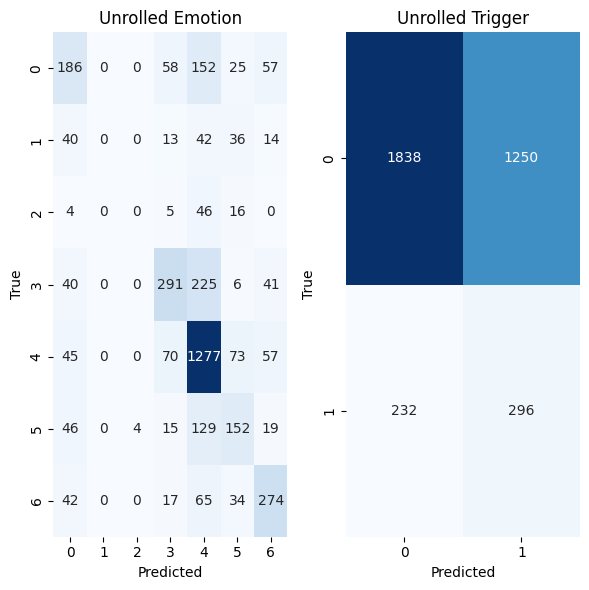

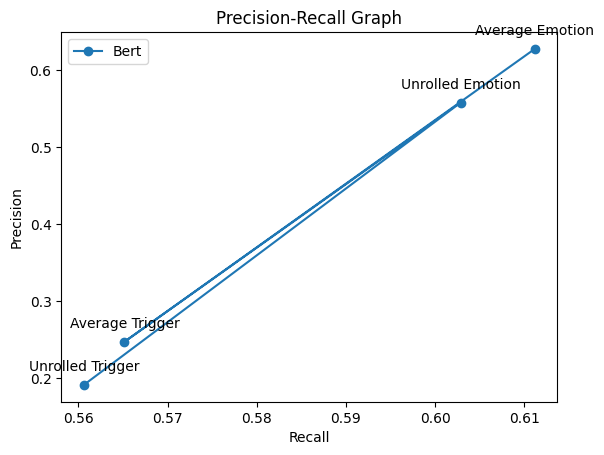

[0.62734336 0.24748515 0.55782932 0.19146183]
[0.61116886 0.56516665 0.60287613 0.56060606]


In [41]:
print_metrics_model(p_Bert,r_Bert,cm_Bert,'Bert')

## Majority

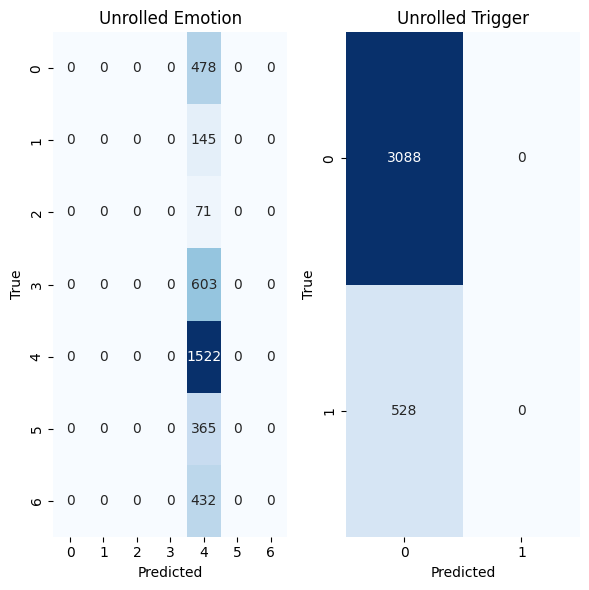

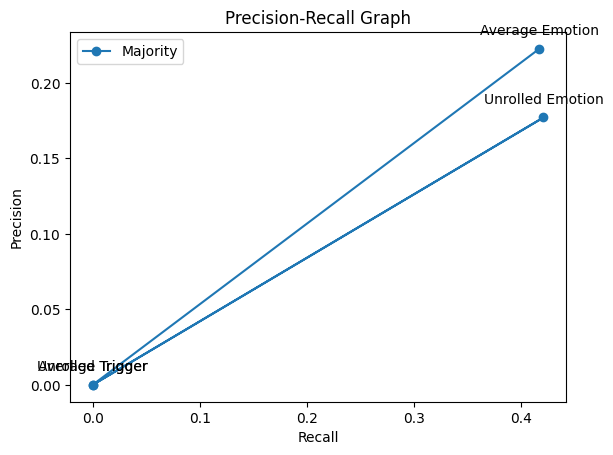

[0.22257783 0.         0.17716277 0.        ]
[0.41683936 0.         0.42090708 0.        ]


In [42]:
print_metrics_model(p_majority,r_majority,cm_majority,'Majority')

## Uniform

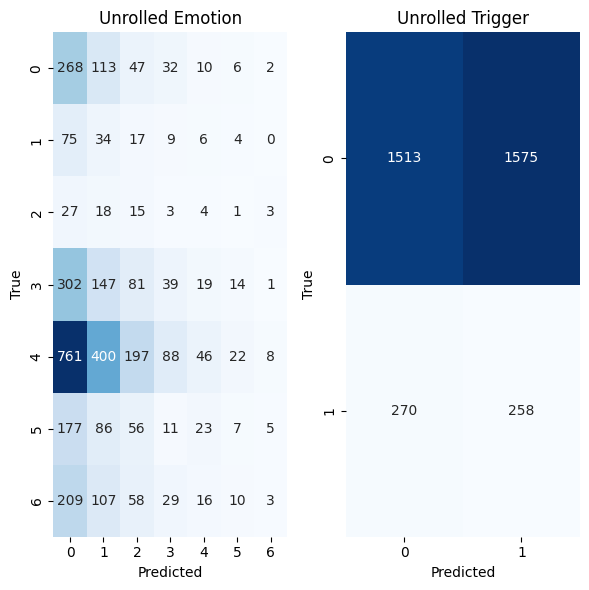

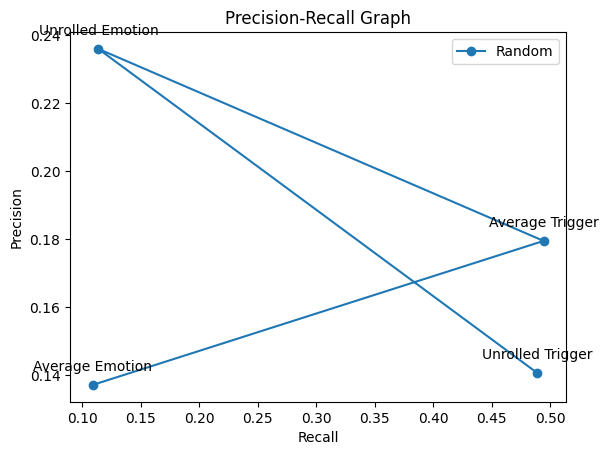

[0.13713638 0.17947121 0.23590514 0.14075287]
[0.10904371 0.49445835 0.11393806 0.48863637]


In [43]:
print_metrics_model(p_random,r_random,cm_random,'Random')

## Bert_LSTM

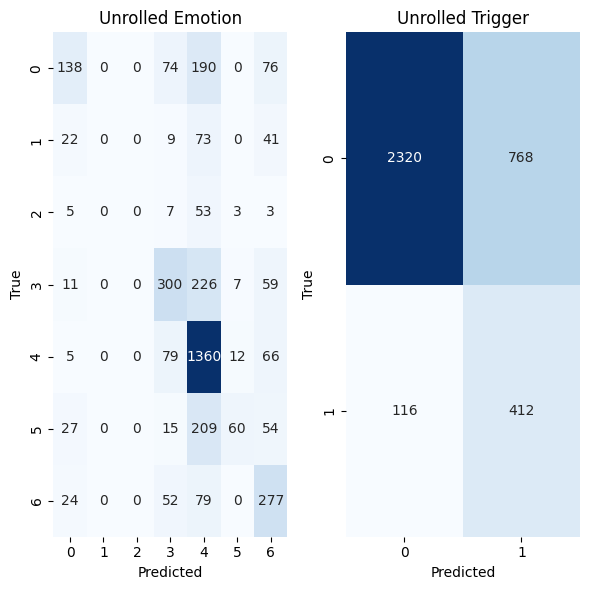

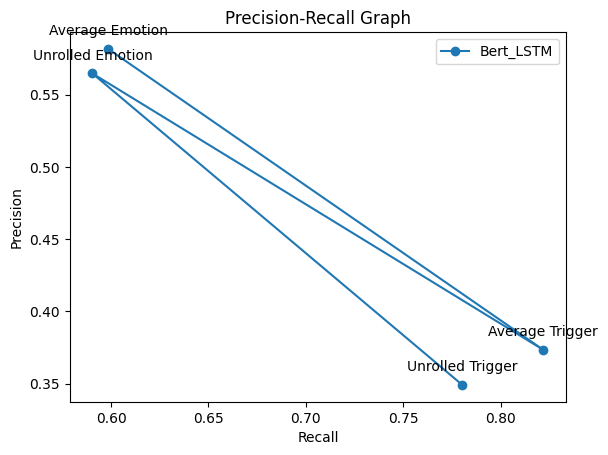

[0.58164877 0.37339881 0.56466252 0.34915254]
[0.59851134 0.82191664 0.59043139 0.780303  ]


In [44]:
print_metrics_model(p_Bert_LSTM,r_Bert_LSTM,cm_Bert_LSTM,'Bert_LSTM')

In [45]:
f1_Bert = convert_tensor_to_array(f1_Bert)
f1_majority = convert_tensor_to_array(f1_majority)
f1_random = convert_tensor_to_array(f1_random)
f1_Bert_LSTM = convert_tensor_to_array(f1_Bert_LSTM)
f1_Bert,f1_majority, f1_random, f1_Bert_LSTM

(array([0.58726394, 0.30909669, 0.57385898, 0.28543878]),
 array([0.28111464, 0.        , 0.24936573, 0.        ]),
 array([0.09849352, 0.23547997, 0.07890815, 0.21855146]),
 array([0.55157232, 0.48345649, 0.54041344, 0.48243558]))

Combined plot to visualise performance of models selected

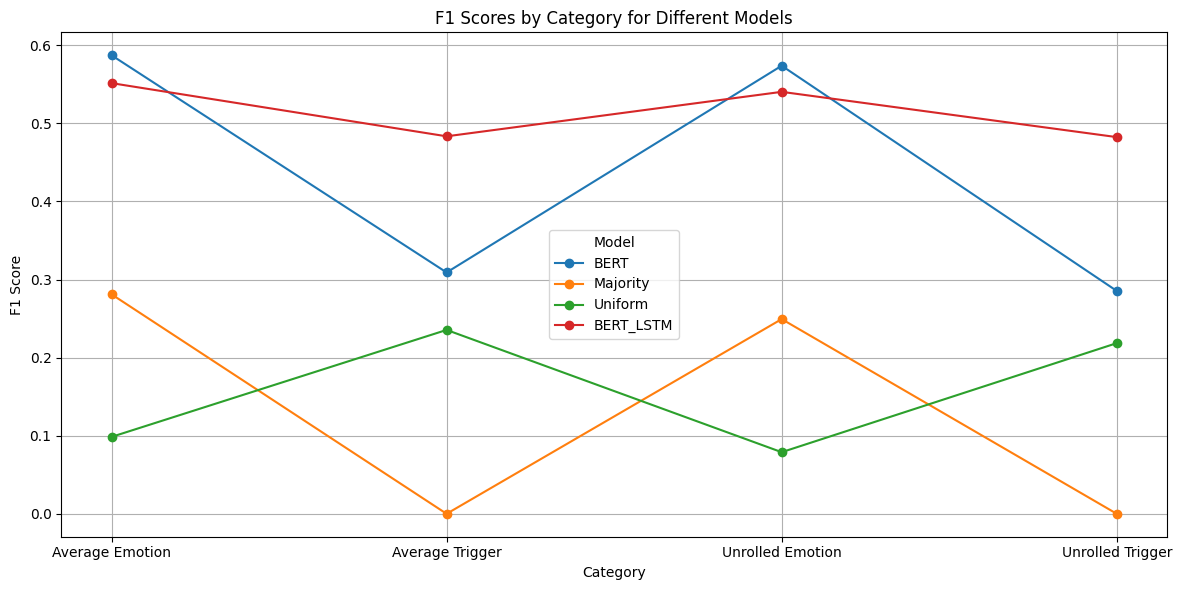

In [46]:
models = ['Bert','Random', 'Uniform', 'Bert_LSTM']
categories = ['Average Emotion', 'Average Trigger', 'Unrolled Emotion', 'Unrolled Trigger']

f1_scores_by_model = {
    'BERT': f1_Bert,
    'Majority': f1_majority,
    'Uniform': f1_random,
    'BERT_LSTM': f1_Bert_LSTM
}

plt.figure(figsize=(12, 6))

for model, f1_scores in f1_scores_by_model.items():
    plt.plot(categories, f1_scores, marker='o', label=model)

plt.title('F1 Scores by Category for Different Models')
plt.xlabel('Category')
plt.ylabel('F1 Score')
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()

plt.show()

## Wrong Predictions

In [47]:
len(input_ids_test), len(attention_mask_test)

(400, 400)

In [ ]:
pred_emotion_list = []
pred_trigger_list = []
for input_ids, attention_mask in tqdm(zip(input_ids_test,attention_mask_test), desc='Evaluation', leave=False):
    prediction = BERT_LSTM(input_ids.to(device),attention_mask.to(device))
    pred_emotion = torch.argmax(prediction[0],dim=1).cpu()
    pred_trigger = torch.argmax(prediction[1],dim=1).cpu()
    pred_emotion_list.append(pred_emotion)
    pred_trigger_list.append(pred_trigger)

In [ ]:
label_emotion_list = []
for dialogue in test_data['emotions']:
    label_emotion_list.append(torch.from_numpy(np.argmax(dialogue,axis=1)))

In [ ]:
label_trigger_list = []
for dialogue in test_data['triggers']:
    label_trigger_list.append(torch.tensor(dialogue))

In [ ]:
def count_wrong_classifications(counter,predictions,labels):
  wrong_classifications = []
  for idx in range(len(predictions)):
    counter_missclassification = 0
    for i,_ in enumerate(predictions[idx]):
      if predictions[idx][i].item() != labels[idx][i].item():
        counter_missclassification+=1
    if counter_missclassification >= counter:
      wrong_classifications.append(idx)
  return wrong_classifications

In [ ]:
threshold = 4 # no. of utterances misclassified in each dialogue
wrong_classifications = count_wrong_classifications(threshold,pred_emotion_list,label_emotion_list)
print('Number of emotion missclassification with threshold',threshold,':',test_data.iloc[wrong_classifications].shape[0])
test_data.iloc[wrong_classifications]

Number of emotion missclassification with threshold 4 : 185


,episode,speakers,emotions,utterances,triggers
8,utterance_3608,"[Rachel, Monica, Rachel, Monica, Rachel, Rachel]","[[0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0],...","[Oh God, I hate my job, I hate it, I hate my j...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
9,utterance_3609,"[Rachel, Monica, Rachel, Monica, Rachel, Rache...","[[0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0],...","[Oh God, I hate my job, I hate it, I hate my j...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]"
10,utterance_3610,"[Rachel, Monica, Rachel, Monica, Rachel, Rache...","[[0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0],...","[Oh God, I hate my job, I hate it, I hate my j...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
11,utterance_3611,"[Rachel, Monica, Rachel, Monica, Rachel, Rache...","[[0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0],...","[Oh God, I hate my job, I hate it, I hate my j...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,utterance_3612,"[Rachel, Monica, Rachel, Monica, Rachel, Rache...","[[0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0],...","[Oh God, I hate my job, I hate it, I hate my j...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
395,utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0],...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
396,utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0],...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
397,utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0],...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
398,utterance_3998,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0],...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
threshold = 3 # no of triggers misclassified in each dialogue
wrong_classifications = count_wrong_classifications(threshold,pred_trigger_list,label_trigger_list)
print('Number of trigger missclassification with threshold',threshold,':',test_data.iloc[wrong_classifications].shape[0])
test_data.iloc[wrong_classifications]

Number of trigger missclassification with threshold 3 : 110


,episode,speakers,emotions,utterances,triggers
1,utterance_3601,"[Jeannine, Julio, Monica, Julio, Monica, Julio...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0],...","[Night Mon. Night Julio., Adiós., Look Julio, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,utterance_3608,"[Rachel, Monica, Rachel, Monica, Rachel, Rachel]","[[0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0],...","[Oh God, I hate my job, I hate it, I hate my j...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
17,utterance_3617,"[Phoebe, Monica, Phoebe, Monica, Monica, Monic...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1],...",[Do you think they have yesterday's daily news...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
18,utterance_3618,"[Phoebe, Monica, Phoebe, Monica, Monica, Monic...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1],...",[Do you think they have yesterday's daily news...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."
22,utterance_3622,"[Monica, The Food Critic, Monica, The Food Cri...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1],...","[Hi! Umm, I'm Monica Geller, I'm the chef at A...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]"
...,...,...,...,...,...
383,utterance_3983,"[Joey, Chandler, Joey, Ross, Chandler, Ross]","[[1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0],...","[What about me?! You-you just said I could!, I...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
386,utterance_3986,"[Joey, Stanley, Joey, Stanley, Joey, Stanley]","[[0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0],...",[Hey-hey! Stanley! Hey-hey! You're leading man...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
388,utterance_3988,"[Joey, Stanley, Joey, Stanley, Joey, Stanley, ...","[[0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0],...",[Hey-hey! Stanley! Hey-hey! You're leading man...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
398,utterance_3998,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[[0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0],...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
